In [105]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve

In [11]:
path_df = "student-mat.csv"

df = pd.read_csv(path_df)

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Feature Engineering

In [15]:
onehot_columns = ['Mjob', 'Fjob', 'reason', 'guardian']
new_onehot_columns = [f"{col}_{category}" for col in onehot_columns for category in col_tf.named_transformers_['OneHot'].categories_[onehot_columns.index(col)][1:]]
ordinal_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'studytime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
minmax_columns = ['age', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'absences', 'G1', 'G2', 'G3']
untransformed_columns = ['Dalc', 'Walc', 'health']

all_column_names = new_onehot_columns + ordinal_columns + minmax_columns + untransformed_columns

In [16]:
col_tf = ColumnTransformer(
    transformers=[
        ('OneHot', OneHotEncoder(drop="first", categories='auto'), ['Mjob','Fjob','reason','guardian']),
        ('Ordinal',OrdinalEncoder(),['school','sex','address','famsize','Pstatus','Medu','Fedu','studytime','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']),
        ('MinMax',MinMaxScaler(),['age','traveltime','studytime','failures','famrel','freetime','goout','absences','G1','G2','G3'])
    ],
    remainder='passthrough'
)

col_tf.fit(df)
new_df = pd.DataFrame(col_tf.transform(df), columns=all_column_names)
new_df["age"]

0      0.428571
1      0.285714
2      0.000000
3      0.000000
4      0.142857
         ...   
390    0.714286
391    0.285714
392    0.857143
393    0.428571
394    0.571429
Name: age, Length: 395, dtype: float64

Analysing the data with a correlation matrix

In [17]:
corr_matrix = new_df.corr()

fig = px.imshow(corr_matrix, 
                text_auto=True, # Automatically add text on each cell
                aspect="auto",  # Let plotly decide aspect ratio
                color_continuous_scale='RdBu') # Color scale

plot(fig, filename='heatmap.html', auto_open=True)

'heatmap.html'

Now it's time to split the train and test

In [18]:
X = new_df.iloc[:, :-3]
y = new_df.iloc[:,-3:]
yDalc, yWalc, yHealth = y[["Dalc"]], y[["Walc"]], y[["health"]]
X_train1, X_test1, yWalc_train, yWAlc_test = train_test_split(X, yWalc, random_state=42, stratify=yWalc)
X_train2, X_test2, yDalc_train, yDAlc_test = train_test_split(X, yDalc, random_state=42, stratify=yDalc)
X_train3, X_test3, yHealth_train, yHealth_test = train_test_split(X, yHealth, random_state=42, stratify=yHealth)

In [ ]:
#only to avoid strange errors
yDalc_train = yDalc_train.values.flatten()
yDAlc_test = yDAlc_test.values.flatten()

And apply an algorithm

Score of KNN with 13 neighboors: 0.696969696969697


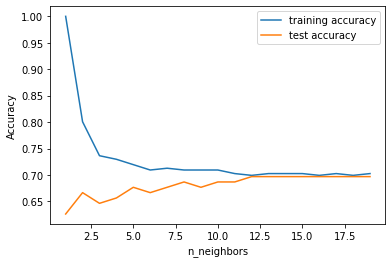

In [61]:
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1, 20)

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train2, yDalc_train)
    training_accuracy.append(clf.score(X_train2, yDalc_train))
    test_accuracy.append(clf.score(X_test2, yDAlc_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

print(f"Score of KNN with 13 neighboors: {test_accuracy[13]}")

It seems that it's easier to predict the daily alcool comsuption with these data, and the best value for knn seems to be around 12.
The reached accuracy is 0.7. I will try with a few other algorithms

Now I'll try to use logistic regression

In [113]:
lr = LogisticRegression(max_iter=300)
lr.fit(X_train2, yDalc_train)
print(f"Logistic Regression score: {lr.score(X_test2,yDAlc_test)}")

Logistic Regression score: 0.6767676767676768


In [137]:
rkf = RepeatedKFold(n_splits=4, n_repeats=3)
print(cross_val_score(lr, X_train2, yDalc_train, cv = rkf))

[0.68918919 0.55405405 0.67567568 0.67567568 0.68918919 0.75675676
 0.60810811 0.63513514 0.71621622 0.64864865 0.62162162 0.7027027 ]


La linear Regression sembra non essere affatto adatta

In [103]:
linr = LinearRegression()
linr.fit(X_train2, yDalc_train)

predictions_linr = linr.predict(X_test2)
rounded_predictions_linr = np.round(predictions_linr)
accuracy = accuracy_score(yDAlc_test, rounded_predictions_linr)

print(f"Linear Regression score: {accuracy}")

Linear Regression score: 0.5757575757575758


Coefficents analysis

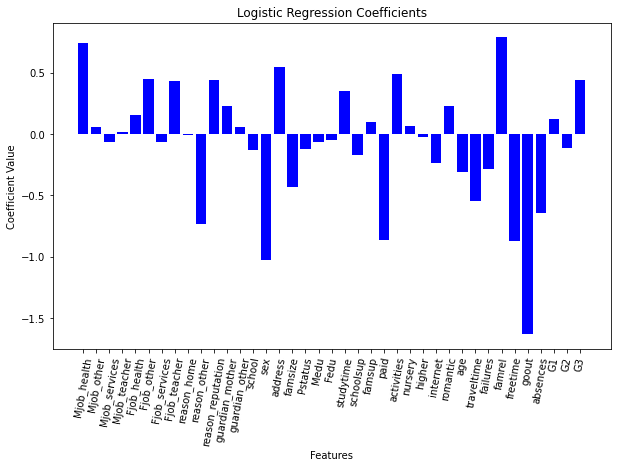

In [48]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation = 80)
plt.bar(all_column_names[:-3], lr.coef_[0], color='blue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()